# <center>$\color{blue}{\text{QEM applied to research in fundamental QM}$

## $\color{blue}{\text{
Libraries
}}$

In [191]:
from qiskit import*
from matplotlib.pyplot import*
from IPython.display import clear_output
from qiskit import *
from qiskit.transpiler import *
from qiskit.transpiler.passes import *
from numpy import *
from qiskit.providers.aer.noise import NoiseModel

## $\color{blue}{\text{
Parameters
}}$

In [318]:
P = 1.0;
phi = pi/2;

## $\color{blue}{\text{
Theoretical model
}}$

In [349]:
def V2(gamma,P,phi):
    return cos(gamma/2)**2+(P**2)*(cos(phi)**2)*sin(gamma/2)**2

def D2(gamma,P,phi):
    return (P**2)*(sin(phi)**2)*sin(gamma/2)**2

## $\color{blue}{\text{
Qiskit ideal simulator
}}$

In [323]:
proc = Aer.get_backend('qasm_simulator')


n_shots = 2000;
n_exp = 10;

v = []
dv = []
g = []

for k in [0,0.5,1,1.5,2,2.5,3,3.5,4]:
    s = []
    sd = []
    gamma = k*pi/2;

    for i in range(72):
        varphi = 5*i*pi/180
        q = QuantumCircuit(3,2)

        q.h(0)
        q.initialize([sqrt(0.5 + P/2),0,0,sqrt(0.5 - P/2)],[2,1])
        q.p(varphi,0)
        q.rx(phi-pi/2,1)
        q.cry(-gamma,0,1)
        q.h(0)

        q.barrier([0,1])

        q.measure([0,1],[0,1])

        job = execute([q for i in range(n_exp)], proc, shots = n_shots)
        counts = job.result().get_counts()

        temp = []

        for j in range(n_exp):
            temp.append((counts[j].get('00',0)+counts[j].get('10',0))/(n_shots))

        s.append(sum(temp)/n_exp)
        sd.append(std(temp))
        
    v.append(((max(s)-min(s))/(max(s)+min(s)))**2)
    dv.append(2*((max(s)-min(s))/(max(s)+min(s)))*sqrt(sd[(where(s == min(s)))[0][0]]**2+sd[(where(s == max(s)))[0][0]]**2)*sqrt( 1/(max(s)+min(s))**2 + (max(s)-min(s))**2/(max(s)+min(s))**4))
    g.append(gamma)

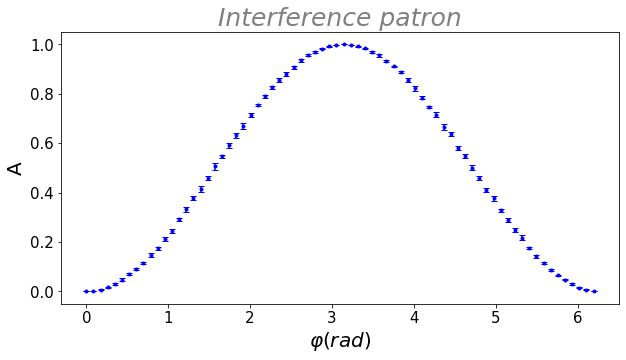

In [269]:
figure(figsize=(10,5))
errorbar([5*i*pi/180 for i in range(72)],s,yerr=sd,fmt='b.',capsize=3);
xticks(fontsize=15)
yticks(fontsize=15)
ylabel(r"A",fontsize=20);
xlabel(r"$\varphi(rad)$",fontsize=20);

#suptitle("A 2D histogram\n", fontsize=18, y=1.02)
title(r'Interference patron',fontsize=25, style='italic', color="grey");

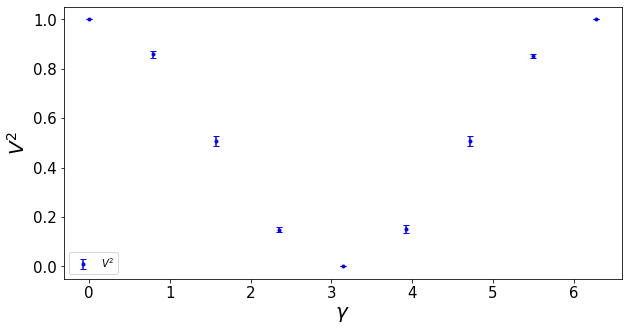

In [270]:
figure(figsize=(10,5))
errorbar(g,v,yerr=dv,fmt='b.', capsize=3,label=r"$V^2$")
xticks(fontsize=15)
yticks(fontsize=15)
ylabel(r"$V^2$",fontsize=20);
xlabel(r"$\gamma$",fontsize=20);
legend();

In [372]:
proc = Aer.get_backend('qasm_simulator')


n_shots = 4000;
n_exp = 20;

# Tomography circuits
qz = QuantumCircuit(3,2)
qz.measure([0,1],[0,1])

qx = QuantumCircuit(3,2)
qx.h(1)
qx.measure([0,1],[0,1])

qy = QuantumCircuit(3,2)
qy.sdg(1)
qy.h(1)
qy.measure([0,1],[0,1])

D = []
dD = []
g = []

for i in [0,0.5,1,1.5,2,2.5,3,3.5,4]:
    
    gamma = i*pi/2;
    
    s1 = []
    ds1 = []

    s2 = []
    ds2 = []

    q = QuantumCircuit(3,2)

    q.h(0)
    q.initialize([sqrt(0.5 + P/2),0,0,sqrt(0.5 - P/2)],[2,1])
    q.rx(phi-pi/2,1)
    q.cry(-gamma,0,1)

    # Tomography part

    q.barrier([0,1])



    job = execute([(q.compose(qx)) for i in range(n_exp)], proc, shots = n_shots)
    counts = job.result().get_counts()

    temp1 = []
    temp2 = []

    for j in range(n_exp):
        temp1.append((counts[j].get('01',0)-counts[j].get('11',0))/(counts[j].get('01',0)+counts[j].get('11',0)))
        temp2.append((counts[j].get('00',0)-counts[j].get('10',0))/(counts[j].get('00',0)+counts[j].get('10',0)))

    s1.append(sum(temp1)/n_exp)
    ds1.append(std(temp1))
    s2.append(sum(temp2)/n_exp)
    ds2.append(std(temp2))



    job = execute([(q.compose(qy)) for i in range(n_exp)], proc, shots = n_shots)
    counts = job.result().get_counts()

    temp1 = []
    temp2 = []

    for j in range(n_exp):
        temp1.append((counts[j].get('01',0)-counts[j].get('11',0))/(counts[j].get('01',0)+counts[j].get('11',0)))
        temp2.append((counts[j].get('00',0)-counts[j].get('10',0))/(counts[j].get('00',0)+counts[j].get('10',0)))

    s1.append(sum(temp1)/n_exp)
    ds1.append(std(temp1))
    s2.append(sum(temp2)/n_exp)
    ds2.append(std(temp2))


    job = execute([(q.compose(qz)) for i in range(n_exp)], proc, shots = n_shots)
    counts = job.result().get_counts()

    temp1 = []
    temp2 = []

    for j in range(n_exp):
        temp1.append((counts[j].get('01',0)-counts[j].get('11',0))/(counts[j].get('01',0)+counts[j].get('11',0)))
        temp2.append((counts[j].get('00',0)-counts[j].get('10',0))/(counts[j].get('00',0)+counts[j].get('10',0)))

    s1.append(sum(temp1)/n_exp)
    ds1.append(std(temp1))
    s2.append(sum(temp2)/n_exp)
    ds2.append(std(temp2))
    
    temp = array(s1)-array(s2)
    
    g.append(gamma)
    D.append((sqrt(sum(temp**2))/2)**2)
    dD.append(sqrt(sum((array(ds1)**2+array(ds2)**2)*(temp**2)))/2)

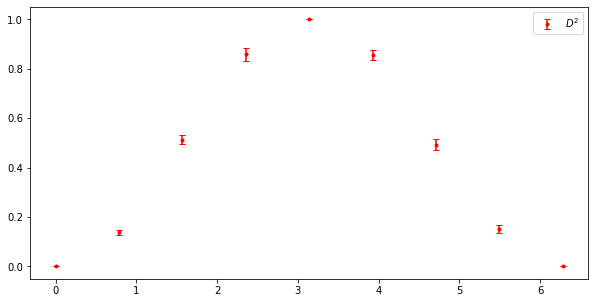

In [320]:
figure(figsize=(10,5))
errorbar(g,D,yerr=dD,fmt='r.', capsize=3,label=r"$D^2$")
legend();

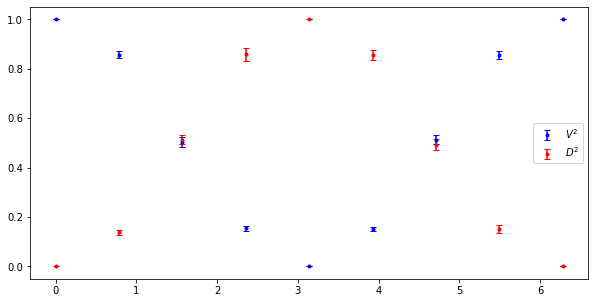

In [324]:
figure(figsize=(10,5))
errorbar(g,v,yerr=dv,fmt='b.', capsize=3,label=r"$V^2$")
errorbar(g,D,yerr=dD,fmt='r.', capsize=3,label=r"$D^2$")
legend();

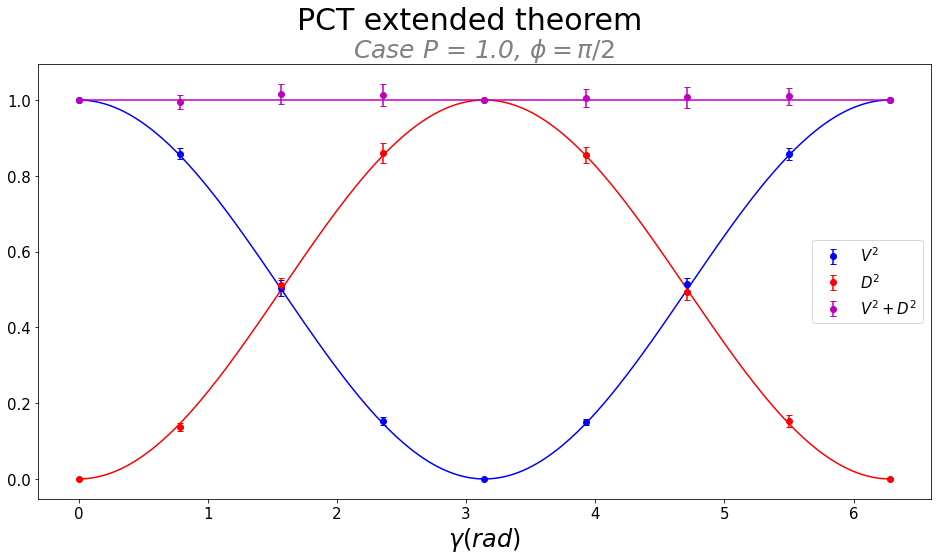

In [325]:
def V2(gamma,P,phi):
    return cos(gamma/2)**2+(P**2)*(cos(phi)**2)*sin(gamma/2)**2

def D2(gamma,P,phi):
    return (P**2)*(sin(phi)**2)*sin(gamma/2)**2

figure(figsize=(16,8))

plot([(i*pi/180) for i in range(360)],[V2(i*pi/180,P,pi/2) for i in range(360)],'b-')
plot([(i*pi/180) for i in range(360)],[D2(i*pi/180,P,pi/2) for i in range(360)],'r-')
plot([(i*pi/180) for i in range(360)],[D2(i*pi/180,P,pi/2)+V2(i*pi/180,P,pi/2) for i in range(360)],'m-')

errorbar(g,v,yerr=dv,fmt='bo', capsize=3,label=r"$V^2$")
errorbar(g,D,yerr=dD,fmt='ro', capsize=3,label=r"$D^2$")
errorbar(g,array(v)+array(D),yerr=sqrt(array(dv)**2+array(dD)**2),fmt='mo', capsize=3,label=r"$V^2+D^2$")
xticks(fontsize=15)
yticks(fontsize=15)
xlabel(r"$\gamma(rad)$",fontsize=24)
legend(loc=5,fontsize=15);
suptitle("PCT extended theorem",fontsize=30);
title("Case P = " + str(P) + r", $\phi = \pi/2$",style='italic', color="grey",fontsize=25);

## $\color{blue}{\text{
Qiskit noise simulator
}}$

In [312]:
proc = Aer.get_backend('qasm_simulator')
provider = IBMQ.load_account();

cmap_quito = [[0, 1], [1, 0], [1, 2], [1, 3], [2, 1], [3, 1], [3, 4], [4, 3]]

mapa = CouplingMap(couplinglist=cmap_quito)
bs = BasicSwap(coupling_map=mapa)
admin = PassManager(bs)

n_shots = 2000;
n_exp = 10;

v = []
dv = []
g = []

for k in [0,0.5,1,1.5,2,2.5,3,3.5,4]:
    s = []
    sd = []
    gamma = k*pi/2;

    for i in range(72):
        varphi = 5*i*pi/180
        q = QuantumCircuit(3,2)

        q.h(0)
        q.initialize([sqrt(0.5 + P/2),0,0,sqrt(0.5 - P/2)],[2,1])
        q.p(varphi,0)
        q.rx(phi-pi/2,1)
        q.cry(-gamma,0,1)
        q.h(0)

        q.barrier([0,1])

        q.measure([0,1],[0,1])
        
        backend = provider.get_backend('ibmq_quito')
        noise_model = NoiseModel.from_backend(backend)
        basis_gates = noise_model.basis_gates

        # Get coupling map from backend
        coupling_map = backend.configuration().coupling_map

        backend = proc
        q2 = admin.run(q)

        job = execute([q2 for i in range(n_exp)],coupling_map=coupling_map,
                    basis_gates=basis_gates,
                    noise_model=noise_model,backend=backend,shots=n_shots)
        counts = job.result().get_counts()

        temp = []

        for j in range(n_exp):
            temp.append((counts[j].get('00',0)+counts[j].get('10',0))/(n_shots))

        s.append(sum(temp)/n_exp)
        sd.append(std(temp))
        
    v.append(((max(s)-min(s))/(max(s)+min(s)))**2)
    dv.append(2*((max(s)-min(s))/(max(s)+min(s)))*sqrt(sd[(where(s == min(s)))[0][0]]**2+sd[(where(s == max(s)))[0][0]]**2)*sqrt( 1/(max(s)+min(s))**2 + (max(s)-min(s))**2/(max(s)+min(s))**4))
    g.append(gamma)

ibmqfactory.load_account:WARNING:2022-01-16 04:20:50,499: Credentials are already in use. The existing account in the session will be replaced.


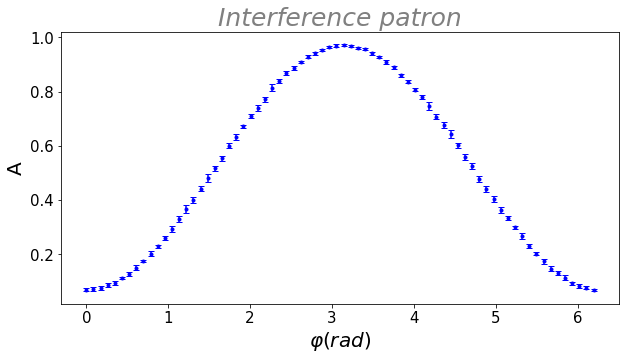

In [313]:
figure(figsize=(10,5))
errorbar([5*i*pi/180 for i in range(72)],s,yerr=sd,fmt='b.',capsize=3);
xticks(fontsize=15)
yticks(fontsize=15)
ylabel(r"A",fontsize=20);
xlabel(r"$\varphi(rad)$",fontsize=20);

#suptitle("A 2D histogram\n", fontsize=18, y=1.02)
title(r'Interference patron',fontsize=25, style='italic', color="grey");

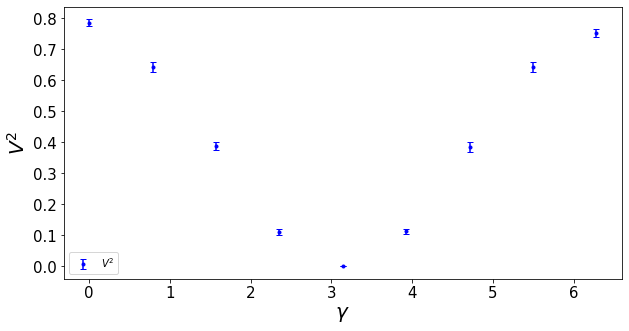

In [315]:
figure(figsize=(10,5))
errorbar(g,v,yerr=dv,fmt='b.', capsize=3,label=r"$V^2$")
xticks(fontsize=15)
yticks(fontsize=15)
ylabel(r"$V^2$",fontsize=20);
xlabel(r"$\gamma$",fontsize=20);
legend();

In [373]:
# Backend del simulador 
proc = Aer.get_backend('qasm_simulator')
# Cargando cuenta de IBM
provider = IBMQ.load_account();

cmap_quito = [[0, 1], [1, 0], [1, 2], [1, 3], [2, 1], [3, 1], [3, 4], [4, 3]]

mapa = CouplingMap(couplinglist=cmap_quito)
bs = BasicSwap(coupling_map=mapa)
admin = PassManager(bs)


n_shots = 4000;
n_exp = 20;

# Tomography circuits
qz = QuantumCircuit(3,2)
qz.measure([0,1],[0,1])

qx = QuantumCircuit(3,2)
qx.h(1)
qx.measure([0,1],[0,1])

qy = QuantumCircuit(3,2)
qy.sdg(1)
qy.h(1)
qy.measure([0,1],[0,1])

D = []
dD = []
g = []

for i in [0,0.5,1,1.5,2,2.5,3,3.5,4]:
    
    gamma = i*pi/2;
    
    s1 = []
    ds1 = []

    s2 = []
    ds2 = []

    q = QuantumCircuit(3,2)

    q.h(0)
    q.initialize([sqrt(0.5 + P/2),0,0,sqrt(0.5 - P/2)],[2,1])
    q.rx(phi-pi/2,1)
    q.cry(-gamma,0,1)

    # Tomography part

    q.barrier([0,1])
    
    
    backend = provider.get_backend('ibmq_quito')
    noise_model = NoiseModel.from_backend(backend)
    basis_gates = noise_model.basis_gates
    
    # Get coupling map from backend
    coupling_map = backend.configuration().coupling_map
    
    backend = proc
    q2 = admin.run(q)



    job = execute([(q2.compose(qx)) for i in range(n_exp)],coupling_map=coupling_map,
                    basis_gates=basis_gates,
                    noise_model=noise_model,backend=backend,shots=n_shots)
    counts = job.result().get_counts()

    temp1 = []
    temp2 = []

    for j in range(n_exp):
        temp1.append((counts[j].get('01',0)-counts[j].get('11',0))/(counts[j].get('01',0)+counts[j].get('11',0)))
        temp2.append((counts[j].get('00',0)-counts[j].get('10',0))/(counts[j].get('00',0)+counts[j].get('10',0)))

    s1.append(sum(temp1)/n_exp)
    ds1.append(std(temp1))
    s2.append(sum(temp2)/n_exp)
    ds2.append(std(temp2))



    job = execute([(q2.compose(qy)) for i in range(n_exp)],coupling_map=coupling_map,
                    basis_gates=basis_gates,
                    noise_model=noise_model,backend=backend,shots=n_shots)
    counts = job.result().get_counts()

    temp1 = []
    temp2 = []

    for j in range(n_exp):
        temp1.append((counts[j].get('01',0)-counts[j].get('11',0))/(counts[j].get('01',0)+counts[j].get('11',0)))
        temp2.append((counts[j].get('00',0)-counts[j].get('10',0))/(counts[j].get('00',0)+counts[j].get('10',0)))

    s1.append(sum(temp1)/n_exp)
    ds1.append(std(temp1))
    s2.append(sum(temp2)/n_exp)
    ds2.append(std(temp2))


    job = execute([(q2.compose(qz)) for i in range(n_exp)],coupling_map=coupling_map,
                    basis_gates=basis_gates,
                    noise_model=noise_model,backend=backend,shots=n_shots)
    counts = job.result().get_counts()

    temp1 = []
    temp2 = []

    for j in range(n_exp):
        temp1.append((counts[j].get('01',0)-counts[j].get('11',0))/(counts[j].get('01',0)+counts[j].get('11',0)))
        temp2.append((counts[j].get('00',0)-counts[j].get('10',0))/(counts[j].get('00',0)+counts[j].get('10',0)))

    s1.append(sum(temp1)/n_exp)
    ds1.append(std(temp1))
    s2.append(sum(temp2)/n_exp)
    ds2.append(std(temp2))
    
    temp = array(s1)-array(s2)
    
    g.append(gamma)
    D.append((sqrt(sum(temp**2))/2)**2)
    dD.append(sqrt(sum((array(ds1)**2+array(ds2)**2)*(temp**2)))/2)

ibmqfactory.load_account:WARNING:2022-01-16 09:31:56,902: Credentials are already in use. The existing account in the session will be replaced.


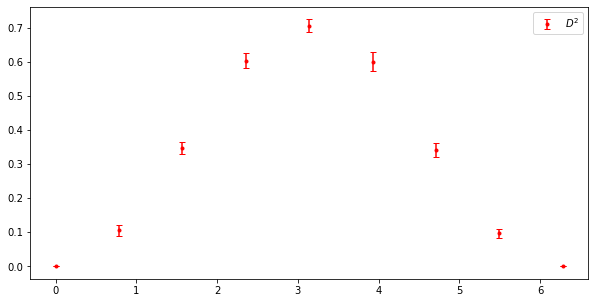

In [310]:
figure(figsize=(10,5))
errorbar(g,D,yerr=dD,fmt='r.', capsize=3,label=r"$D^2$")
legend();

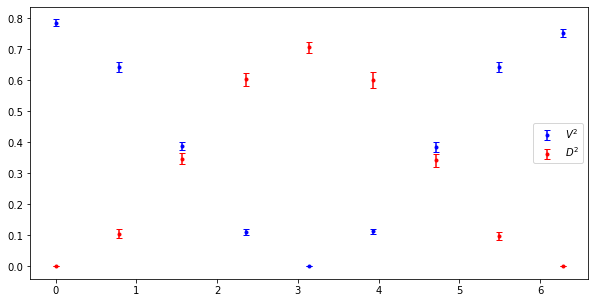

In [316]:
figure(figsize=(10,5))
errorbar(g,v,yerr=dv,fmt='b.', capsize=3,label=r"$V^2$")
errorbar(g,D,yerr=dD,fmt='r.', capsize=3,label=r"$D^2$")
legend();

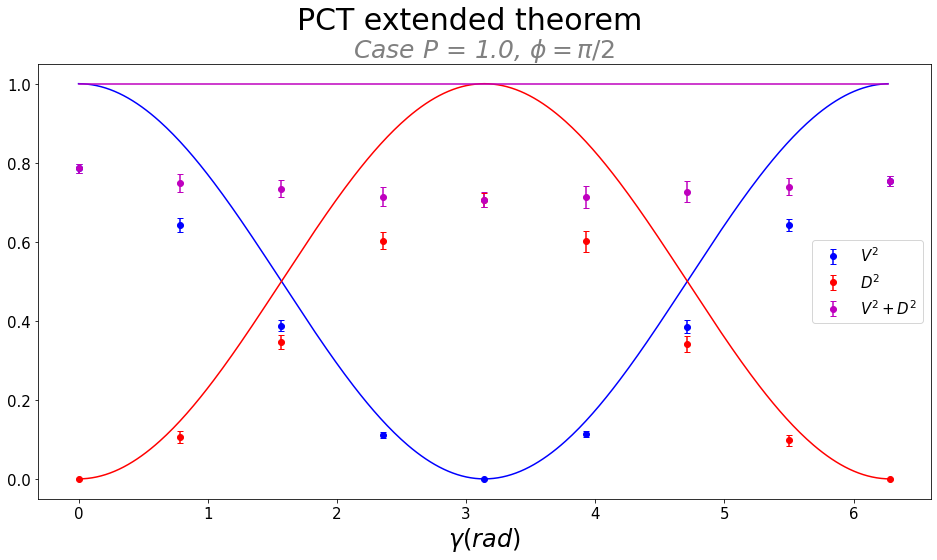

In [317]:
figure(figsize=(16,8))

plot([(i*pi/180) for i in range(360)],[V2(i*pi/180,P,pi/2) for i in range(360)],'b-')
plot([(i*pi/180) for i in range(360)],[D2(i*pi/180,P,pi/2) for i in range(360)],'r-')
plot([(i*pi/180) for i in range(360)],[D2(i*pi/180,P,pi/2)+V2(i*pi/180,P,pi/2) for i in range(360)],'m-')

errorbar(g,v,yerr=dv,fmt='bo', capsize=3,label=r"$V^2$")
errorbar(g,D,yerr=dD,fmt='ro', capsize=3,label=r"$D^2$")
errorbar(g,array(v)+array(D),yerr=sqrt(array(dv)**2+array(dD)**2),fmt='mo', capsize=3,label=r"$V^2+D^2$")
xticks(fontsize=15)
yticks(fontsize=15)
xlabel(r"$\gamma(rad)$",fontsize=24)
legend(loc=5,fontsize=15);
suptitle("PCT extended theorem",fontsize=30);
title("Case P = " + str(P) + r", $\phi = \pi/2$",style='italic', color="grey",fontsize=25);

## $\color{blue}{\text{
Quantum error mitigation process
}}$

In this case I've used the zero noise extrapolation method to get the best value to D, for this method it's necessary to increase the error sistematically and then make a fit evaluating at 0 noise

In [ ]:
proc = Aer.get_backend('qasm_simulator')
provider = IBMQ.load_account();

cmap_quito = [[0, 1], [1, 0], [1, 2], [1, 3], [2, 1], [3, 1], [3, 4], [4, 3]]

mapa = CouplingMap(couplinglist=cmap_quito)
bs = BasicSwap(coupling_map=mapa)
admin = PassManager(bs)

n_shots = 2000;
n_exp = 10;

v = []
dv = []
g = []

for k in [0,0.5,1,1.5,2,2.5,3,3.5,4]:
    s = []
    sd = []
    gamma = k*pi/2;

    for i in range(72):
        varphi = 5*i*pi/180
        q = QuantumCircuit(3,2)

        q.h(0)
        q.initialize([sqrt(0.5 + P/2),0,0,sqrt(0.5 - P/2)],[2,1])
        q.p(varphi,0)
        q.rx(phi-pi/2,1)
        q.cry(-gamma,0,1)
        q.h(0)
        
        # Adding error 

        q.barrier([0,1])
        
        q.h(0)
        q.cry(gamma,0,1)
        q.rx(-phi+pi/2,1)
        q.p(-varphi,0)
        q.h(0)
    
        q.barrier()
        
        q.h(0)
        q.p(varphi,0)
        q.rx(phi-pi/2,1)
        q.cry(-gamma,0,1)
        q.h(0)
        
        q.barrier()

        q.measure([0,1],[0,1])
        
        backend = provider.get_backend('ibmq_quito')
        noise_model = NoiseModel.from_backend(backend)
        basis_gates = noise_model.basis_gates

        # Get coupling map from backend
        coupling_map = backend.configuration().coupling_map

        backend = proc
        q2 = admin.run(q)

        job = execute([q2 for i in range(n_exp)],coupling_map=coupling_map,
                    basis_gates=basis_gates,
                    noise_model=noise_model,backend=backend,shots=n_shots)
        counts = job.result().get_counts()

        temp = []

        for j in range(n_exp):
            temp.append((counts[j].get('00',0)+counts[j].get('10',0))/(n_shots))

        s.append(sum(temp)/n_exp)
        sd.append(std(temp))
        
    v.append(((max(s)-min(s))/(max(s)+min(s)))**2)
    dv.append(2*((max(s)-min(s))/(max(s)+min(s)))*sqrt(sd[(where(s == min(s)))[0][0]]**2+sd[(where(s == max(s)))[0][0]]**2)*sqrt( 1/(max(s)+min(s))**2 + (max(s)-min(s))**2/(max(s)+min(s))**4))
    g.append(gamma)

In [401]:
# Backend del simulador 
proc = Aer.get_backend('qasm_simulator')
# Cargando cuenta de IBM
provider = IBMQ.load_account();

cmap_quito = [[0, 1], [1, 0], [1, 2], [1, 3], [2, 1], [3, 1], [3, 4], [4, 3]]

mapa = CouplingMap(couplinglist=cmap_quito)
bs = BasicSwap(coupling_map=mapa)
admin = PassManager(bs)


n_shots = 4000;
n_exp = 20;

# Tomography circuits
qz = QuantumCircuit(3,2)
qz.measure([0,1],[0,1])

qx = QuantumCircuit(3,2)
qx.h(1)
qx.measure([0,1],[0,1])

qy = QuantumCircuit(3,2)
qy.sdg(1)
qy.h(1)
qy.measure([0,1],[0,1])

D = []
dD = []
g = []

for i in [0,0.5,1,1.5,2,2.5,3,3.5,4]:
    
    gamma = i*pi/2;
    
    s1 = []
    ds1 = []

    s2 = []
    ds2 = []

    q = QuantumCircuit(3,2)

    q.h(0)
    q.initialize([sqrt(0.5 + P/2),0,0,sqrt(0.5 - P/2)],[2,1])
    q.rx(phi-pi/2,1)
    q.cry(-gamma,0,1)
    
    # Adding error to the model
    qaux = QuantumCircuit(3,2)
    qaux.barrier()
    qaux.cry(gamma,0,1)
    qaux.rx(-phi+pi/2,1)
    qaux.h(0)
    qaux.barrier()
    
    qaux2 = QuantumCircuit(3,2)
    qaux2.barrier()
    qaux2.h(0)
    qaux2.rx(phi-pi/2,1)
    qaux2.cry(-gamma,0,1)
    qaux2.barrier()

    q.barrier([0,1])
    
    
    backend = provider.get_backend('ibmq_quito')
    noise_model = NoiseModel.from_backend(backend)
    basis_gates = noise_model.basis_gates
    
    # Get coupling map from backend
    coupling_map = backend.configuration().coupling_map
    
    backend = proc
    q2 = admin.run(q)



    job = execute([(q2.compose(qaux).compose(qaux2).compose(qaux).compose(qaux2).compose(qaux).compose(qaux2).compose(qaux).compose(qaux2).compose(qx)) for i in range(n_exp)],coupling_map=coupling_map,
                    basis_gates=basis_gates,
                    noise_model=noise_model,backend=backend,shots=n_shots)
    counts = job.result().get_counts()

    temp1 = []
    temp2 = []

    for j in range(n_exp):
        temp1.append((counts[j].get('01',0)-counts[j].get('11',0))/(counts[j].get('01',0)+counts[j].get('11',0)))
        temp2.append((counts[j].get('00',0)-counts[j].get('10',0))/(counts[j].get('00',0)+counts[j].get('10',0)))

    s1.append(sum(temp1)/n_exp)
    ds1.append(std(temp1))
    s2.append(sum(temp2)/n_exp)
    ds2.append(std(temp2))



    job = execute([(q2.compose(qaux).compose(qaux2).compose(qaux).compose(qaux2).compose(qaux).compose(qaux2).compose(qaux).compose(qaux2).compose(qy)) for i in range(n_exp)],coupling_map=coupling_map,
                    basis_gates=basis_gates,
                    noise_model=noise_model,backend=backend,shots=n_shots)
    counts = job.result().get_counts()

    temp1 = []
    temp2 = []

    for j in range(n_exp):
        temp1.append((counts[j].get('01',0)-counts[j].get('11',0))/(counts[j].get('01',0)+counts[j].get('11',0)))
        temp2.append((counts[j].get('00',0)-counts[j].get('10',0))/(counts[j].get('00',0)+counts[j].get('10',0)))

    s1.append(sum(temp1)/n_exp)
    ds1.append(std(temp1))
    s2.append(sum(temp2)/n_exp)
    ds2.append(std(temp2))


    job = execute([(q2.compose(qaux).compose(qaux2).compose(qaux).compose(qaux2).compose(qaux).compose(qaux2).compose(qaux).compose(qaux2).compose(qz)) for i in range(n_exp)],coupling_map=coupling_map,
                    basis_gates=basis_gates,
                    noise_model=noise_model,backend=backend,shots=n_shots)
    counts = job.result().get_counts()

    temp1 = []
    temp2 = []

    for j in range(n_exp):
        temp1.append((counts[j].get('01',0)-counts[j].get('11',0))/(counts[j].get('01',0)+counts[j].get('11',0)))
        temp2.append((counts[j].get('00',0)-counts[j].get('10',0))/(counts[j].get('00',0)+counts[j].get('10',0)))

    s1.append(sum(temp1)/n_exp)
    ds1.append(std(temp1))
    s2.append(sum(temp2)/n_exp)
    ds2.append(std(temp2))
    
    temp = array(s1)-array(s2)
    
    g.append(gamma)
    D.append((sqrt(sum(temp**2))/2)**2)
    dD.append(sqrt(sum((array(ds1)**2+array(ds2)**2)*(temp**2)))/2)

ibmqfactory.load_account:WARNING:2022-01-16 09:40:45,380: Credentials are already in use. The existing account in the session will be replaced.


In [402]:
# Saving data of each run
D5=D
dD5=dD

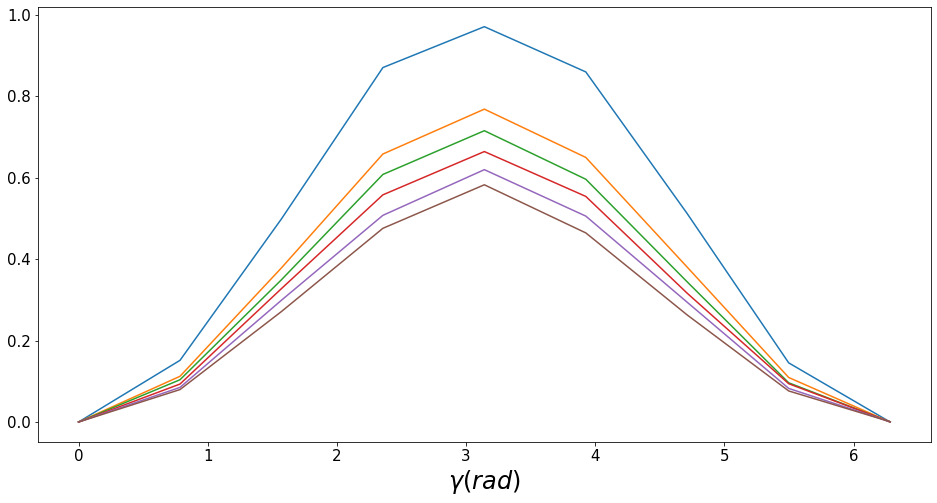

In [445]:
figure(figsize=(16,8))
plot(g,array(Df)**2)
plot(g,D1)
plot(g,D2)
plot(g,D3)
plot(g,D4)
plot(g,D5)
xlabel(r"$\gamma(rad)$",fontsize=24)
xticks(fontsize=15)
yticks(fontsize=15);

In [421]:
from scipy.optimize import curve_fit

def func(x, a, b):
    return a*exp(b * sqrt(x))

Df = []

for i in range(len(D1)):
    xdata=array([1,2,3,4,5])
    ydata=array([D1[i],D3[i],D5[i],D7[i],D9[i]])
    popt, pcov = curve_fit(func, xdata, sqrt(ydata))
    Df.append(func(0,*popt))

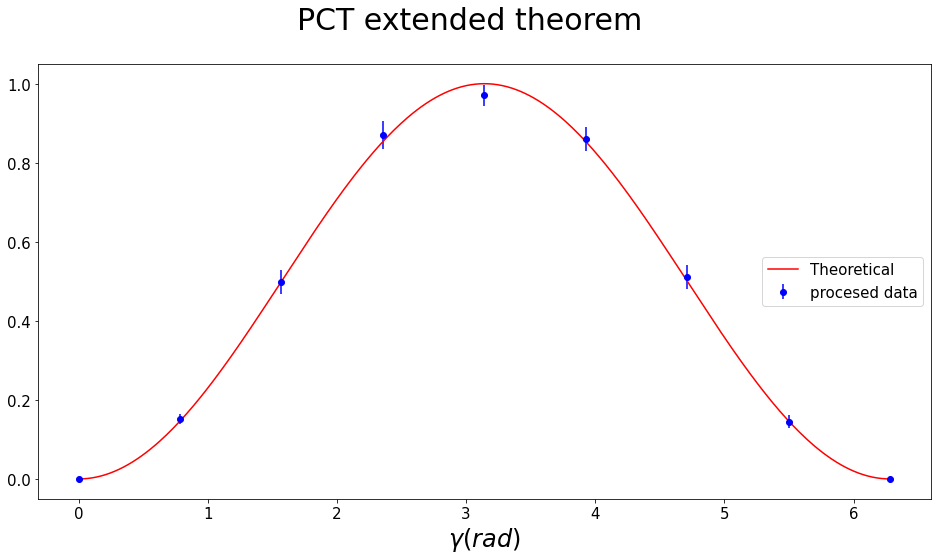

In [442]:
figure(figsize=(16,8))
errorbar(g,array(Df)**2,yerr=2*array(dD1),fmt='bo',label='procesed data')
plot([(i*pi/180) for i in range(360)],[D2(i*pi/180,P,pi/2) for i in range(360)],'r-',label='Theoretical');
xticks(fontsize=15)
yticks(fontsize=15)
xlabel(r"$\gamma(rad)$",fontsize=24)
legend(loc=5,fontsize=15);
suptitle("PCT extended theorem",fontsize=30);